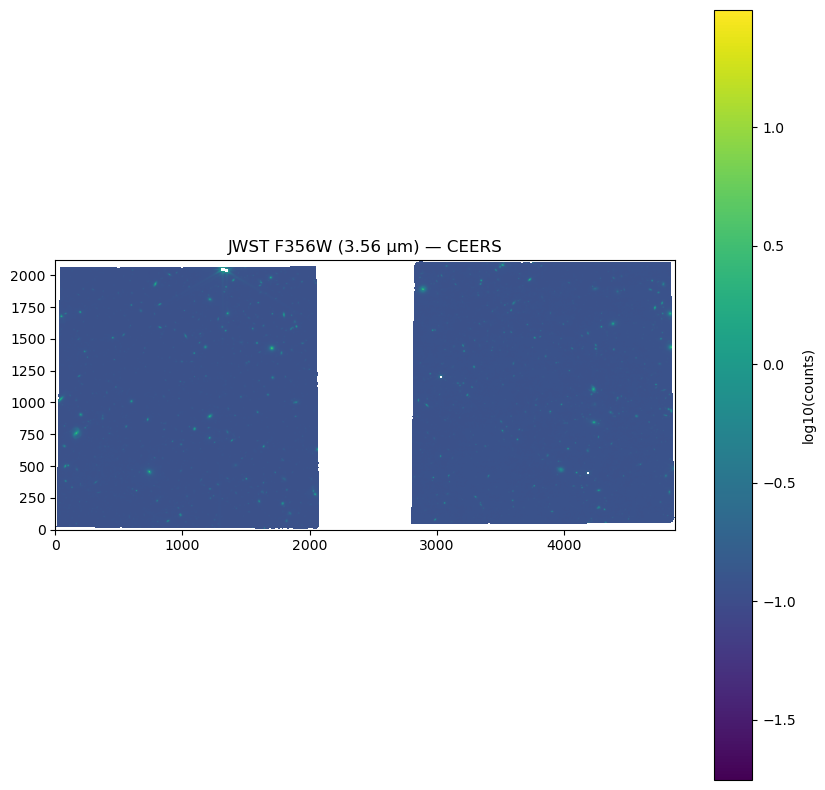

In [1]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np

# Path to your file — update ONLY if your folder name differs
filename = "mast_data_testing/MAST_2025-11-16T1714/JWST/jw01345-o070_t053_nircam_clear-f356w/jw01345-o070_t053_nircam_clear-f356w_i2d.fits"

# Open FITS file
hdul = fits.open(filename)
data = hdul[1].data   # JWST science is usually in extension 1

plt.figure(figsize=(10,10))
plt.imshow(np.log10(data), origin='lower')
plt.colorbar(label='log10(counts)')
plt.title("JWST F356W (3.56 μm) — CEERS")
plt.show()


In [2]:
# Core imports
from astropy.io import fits
from astropy.wcs import WCS
from astropy.convolution import convolve, Gaussian2DKernel
from astropy.stats import SigmaClip
from photutils.background import Background2D, MedianBackground
from photutils.segmentation import detect_threshold, detect_sources, deblend_sources, SourceCatalog
import numpy as np
import matplotlib.pyplot as plt

# Helper to convert Quantity/Masked columns -> plain float arrays
def q_to_float(col):
    try:
        arr = np.ma.filled(col.to_value(), np.nan).astype(float)
    except Exception:
        arr = np.ma.filled(col, np.nan).astype(float)
    return np.asarray(arr)


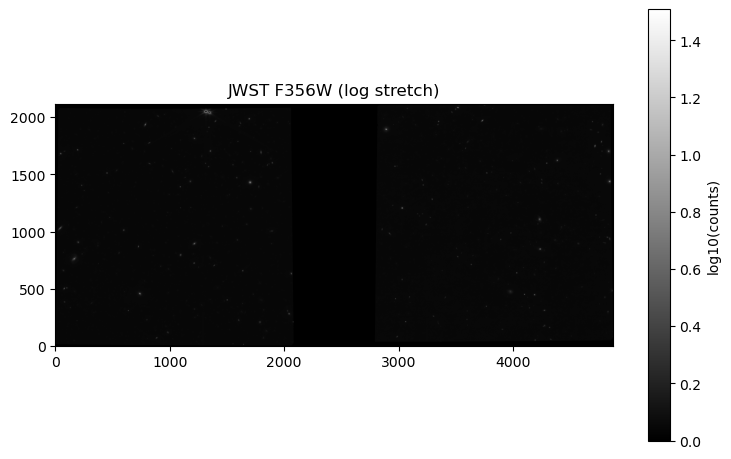

In [3]:
filename = "mast_data_testing/MAST_2025-11-16T1714/JWST/jw01345-o070_t053_nircam_clear-f356w/jw01345-o070_t053_nircam_clear-f356w_i2d.fits"

hdul = fits.open(filename)
data = hdul[1].data.astype(float)       # science array
hdr  = hdul[1].header                   # header for WCS
hdul.close()

# sanitize
data = np.where(np.isfinite(data), data, 0.0)

plt.figure(figsize=(9,7))
plt.imshow(np.log10(data + 1), origin='lower', cmap='gray')
plt.title("JWST F356W (log stretch)")
plt.colorbar(shrink=0.8, label='log10(counts)')
plt.show()


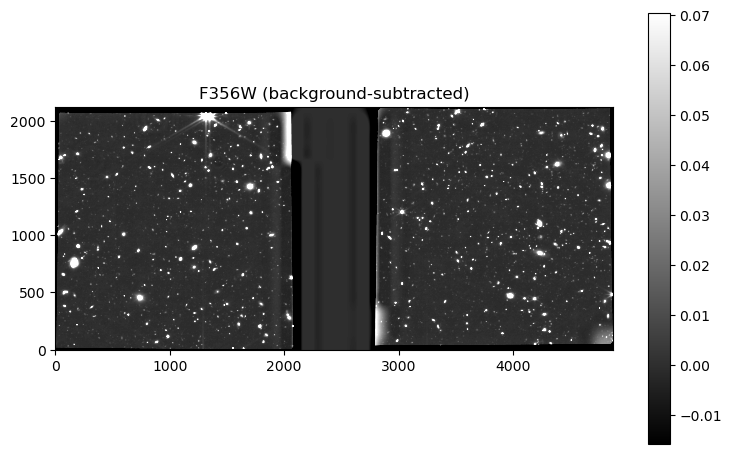

In [4]:
sigma_clip = SigmaClip(sigma=3.0, maxiters=5)
bkg = Background2D(
    data, box_size=(96, 96), filter_size=(3, 3),
    bkg_estimator=MedianBackground(), sigma_clip=sigma_clip
)
resid = data - bkg.background

vmin, vmax = np.percentile(resid, 5), np.percentile(resid, 99)
plt.figure(figsize=(9,7))
plt.imshow(resid, origin='lower', cmap='gray', vmin=vmin, vmax=vmax)
plt.title("F356W (background-subtracted)")
plt.colorbar(shrink=0.8)
plt.show()


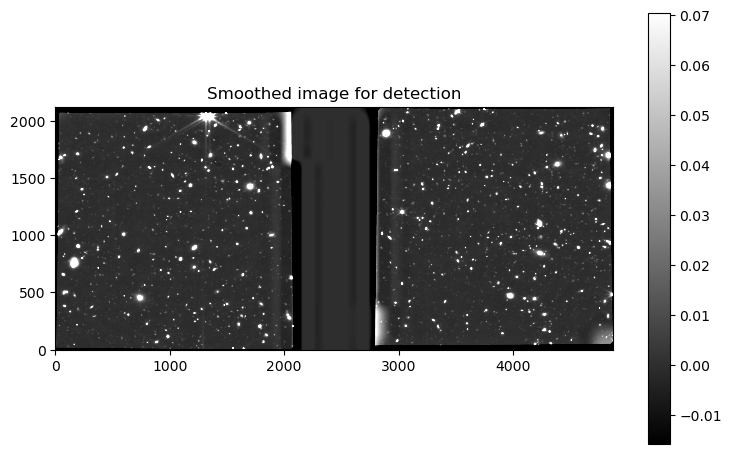

In [5]:
kernel = Gaussian2DKernel(x_stddev=1.0)   # mild PSF-ish smoothing
smooth = convolve(resid, kernel, normalize_kernel=True, boundary='extend')

plt.figure(figsize=(9,7))
plt.imshow(smooth, origin='lower', cmap='gray', vmin=vmin, vmax=vmax)
plt.title("Smoothed image for detection")
plt.colorbar(shrink=0.8)
plt.show()


Deblending:   0%|          | 0/1938 [00:00<?, ?it/s]

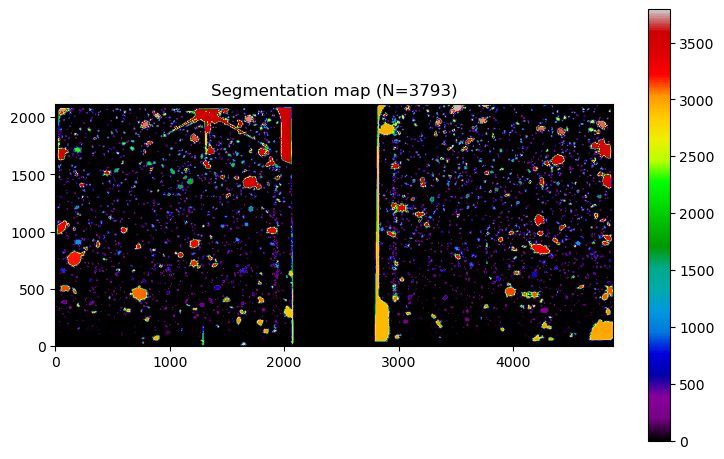

In [6]:
thresh = detect_threshold(smooth, nsigma=3.0)
segm = detect_sources(smooth, thresh, npixels=20)
segm = deblend_sources(smooth, segm, npixels=20, nlevels=32, contrast=0.001)

plt.figure(figsize=(9,7))
plt.imshow(segm.data, origin='lower', cmap='nipy_spectral')
plt.title(f"Segmentation map (N={len(segm.labels)})")
plt.colorbar(shrink=0.8)
plt.show()


In [7]:
# Build initial catalog from segmentation
cat = SourceCatalog(data=resid, segment_img=segm)
tab0 = cat.to_table(columns=("label","area","semimajor_sigma","semiminor_sigma",
                             "xcentroid","ycentroid","kron_flux"))

# Compute ellipticity & prune tiny/elongated detections
area = q_to_float(tab0["area"])
a    = q_to_float(tab0["semimajor_sigma"])
b    = q_to_float(tab0["semiminor_sigma"])

with np.errstate(divide='ignore', invalid='ignore'):
    ell = 1.0 - (b / np.where(a > 0, a, np.nan))

min_area = 40.0
max_ell  = 0.95
keep_mask   = (area >= min_area) & np.isfinite(ell) & (ell < max_ell)
keep_labels = list(tab0["label"][keep_mask])

drop_labels = [lab for lab in segm.labels if lab not in keep_labels]
if drop_labels:
    segm.remove_labels(drop_labels)

# Show how many survived
print(f"Kept {len(segm.labels)} sources after quality cuts.")


/opt/anaconda3/lib/python3.9/site-packages/gwcs/__init__.py:61: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


Kept 2559 sources after quality cuts.


In [8]:
cat_clean = SourceCatalog(data=resid, segment_img=segm)
tbl = cat_clean.to_table(columns=("label","xcentroid","ycentroid","kron_flux",
                                  "area","semimajor_sigma","semiminor_sigma"))
tbl[:12]   # preview first 12 rows

# Build WCS from the science-extension header (fallback to primary if needed)
try:
    w = WCS(hdr)
except Exception:
    w = WCS(fits.getheader(filename, 0))

sky = w.pixel_to_world(tbl["xcentroid"], tbl["ycentroid"])
tbl["ra_deg"]  = sky.ra.to_value("deg")
tbl["dec_deg"] = sky.dec.to_value("deg")

# Show first rows with coordinates
tbl[["label","xcentroid","ycentroid","ra_deg","dec_deg"]][:12]


Set DATE-AVG to '2022-12-25T01:38:01.314' from MJD-AVG.
Set DATE-END to '2022-12-25T02:04:51.822' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to     8.382999 from OBSGEO-[XYZ].
Set OBSGEO-H to 1681495700.587 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


label,xcentroid,ycentroid,ra_deg,dec_deg
int64,float64,float64,float64,float64
3,1358.652864211249,10.721468064685858,214.96460244816407,52.82868319673757
4,1005.2675420471497,13.991828082922396,214.97119485376567,52.83340275402417
5,948.6508619855341,14.002850841281049,214.97226242053657,52.83415300683238
7,1963.023096502345,12.920119104647,214.9531603681714,52.8206995736842
9,668.8183732859007,20.353751601006486,214.97740140539352,52.83793279930635
10,852.5944569117123,19.325471998621477,214.9739574268078,52.83548630653765
11,938.6986417949794,18.074804615543396,214.97236082356093,52.83433126171346
12,1253.3554185393114,18.65921831085791,214.9664139136204,52.8301688445598
13,500.08033915325706,19.0057092731848,214.9806141833286,52.84015289129068


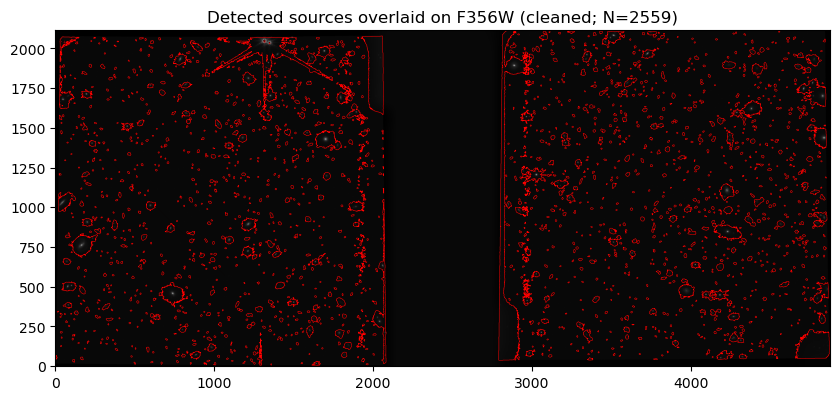

Saved: detections_f356w_with_coords.csv   (columns include RA/Dec)


In [9]:
plt.figure(figsize=(10,6))
plt.imshow(np.log10(resid + 1), origin='lower', cmap='gray')
plt.contour(segm.data > 0, levels=[0.5], colors='r', linewidths=0.35)
plt.title(f"Detected sources overlaid on F356W (cleaned; N={len(segm.labels)})")
plt.show()

out_csv = "detections_f356w_with_coords.csv"
tbl.write(out_csv, format="ascii.csv", overwrite=True)
print(f"Saved: {out_csv}   (columns include RA/Dec)")


# Testing

In [13]:
# --- minimal imports ---
from astropy.io import fits
from astropy.wcs import WCS
from astropy.table import Table
from astropy.nddata import Cutout2D
from astropy.visualization import ZScaleInterval
from astropy.convolution import convolve, Gaussian2DKernel
from photutils.aperture import CircularAperture, CircularAnnulus, aperture_photometry
import numpy as np, matplotlib.pyplot as plt, os

# --- point to your mosaics (update paths you actually have) ---
FILES = {
    "F356W": "mast_data_testing/MAST_2025-11-16T1714/JWST/jw01345-o070_t053_nircam_clear-f356w/jw01345-o070_t053_nircam_clear-f356w_i2d.fits",
    # add more when ready: "F200W": "...", "F444W": "...", "F560W": "...", etc.
}
BANDS = [b for b,v in FILES.items() if v]

# --- where seeds may come from ---
SEED_FILE        = "lrd_candidates_seed_ecsv.ecsv"   # preferred: has RA/Dec
DETECTIONS_TABLE = "detections_F356W_clean.ecsv"     # fallback: has x/y

def load_sci_wcs(path):
    with fits.open(path) as hdul:
        hdr   = hdul[1].header
        data  = hdul[1].data.astype(float)
        w     = WCS(hdr)
        pix_sr = hdr.get("PIXAR_SR", None)   # steradian per pixel (for MJy/sr -> Jy)
        bunit  = hdr.get("BUNIT", None)      # e.g., 'MJy/sr'
    data = np.where(np.isfinite(data), data, 0.0)
    return data, w, pix_sr, bunit

def standardize_seed_table(t):
    """Return a table with columns: idx, ra, dec.
       Will infer idx if absent, and transform x/y -> ra/dec if needed."""
    # if we already have RA/Dec
    has_ra = "ra" in t.colnames
    has_dec = "dec" in t.colnames
    if has_ra and has_dec:
        out = Table()
        out["ra"]  = np.array(t["ra"], float)
        out["dec"] = np.array(t["dec"], float)
        # idx: prefer existing label/id if present, else row number
        if "idx" in t.colnames:
            out["idx"] = np.array(t["idx"], int)
        elif "label" in t.colnames:
            out["idx"] = np.array(t["label"], int)
        elif "id" in t.colnames:
            out["idx"] = np.array(t["id"], int)
        else:
            out["idx"] = np.arange(len(out))
        return out

    # else: try to convert x/y -> RA/Dec using F356W WCS
    if ("xcentroid" in t.colnames) and ("ycentroid" in t.colnames) and ("F356W" in FILES):
        img, w, _ = load_sci_wcs(FILES["F356W"])
        x = np.array(t["xcentroid"], float)
        y = np.array(t["ycentroid"], float)
        ra, dec = w.pixel_to_world_values(x, y)
        out = Table()
        out["ra"], out["dec"] = ra.astype(float), dec.astype(float)
        if "idx" in t.colnames:
            out["idx"] = np.array(t["idx"], int)
        elif "label" in t.colnames:
            out["idx"] = np.array(t["label"], int)
        elif "id" in t.colnames:
            out["idx"] = np.array(t["id"], int)
        else:
            out["idx"] = np.arange(len(out))
        return out

    raise RuntimeError("Seed table lacks RA/Dec and x/y. Provide RA/Dec (SEED_FILE) or x/y (DETECTIONS_TABLE).")

def ensure_seed_table():
    if os.path.exists(SEED_FILE):
        t = Table.read(SEED_FILE, format="ascii.ecsv")
        return standardize_seed_table(t)
    if os.path.exists(DETECTIONS_TABLE):
        t = Table.read(DETECTIONS_TABLE, format="ascii.ecsv")
        return standardize_seed_table(t)
    raise RuntimeError("No seed sources found. Create lrd_candidates_seed_ecsv.ecsv or detections_F356W_clean.ecsv.")

def jy_to_abmag(f_jy):
    with np.errstate(divide='ignore', invalid='ignore'):
        return -2.5 * np.log10(f_jy / 3631.0)

def mjysr_sum_to_jy(sum_mjysr, pix_sr):
    return sum_mjysr * 1e6 * pix_sr

seed = ensure_seed_table()
print(f"Bands found: {BANDS} | Seed positions: {len(seed)} | Columns: {seed.colnames}")


Bands found: ['F356W'] | Seed positions: 2559 | Columns: ['ra', 'dec', 'idx']


idx  band          f_jy                ABmag        bunit         pix_sr       
--- ----- ---------------------- ------------------ ------ --------------------
  3 F356W 3.3604735131022446e-07  25.08406443056475 MJy/sr 9.30201185040463e-14
  4 F356W  4.095390581812843e-07 24.869327304271287 MJy/sr 9.30201185040463e-14
  5 F356W 2.8579042441661667e-07 25.259946438792614 MJy/sr 9.30201185040463e-14
  7 F356W 3.7790755538372435e-07 24.956601685499358 MJy/sr 9.30201185040463e-14
  9 F356W 4.1650491788023484e-07  24.85101528802342 MJy/sr 9.30201185040463e-14
 10 F356W 3.8462759025398195e-07 24.937464537286292 MJy/sr 9.30201185040463e-14
 11 F356W 2.9696475614229616e-07   25.2183033468104 MJy/sr 9.30201185040463e-14
 12 F356W  5.371930506163825e-07 24.574739657797235 MJy/sr 9.30201185040463e-14
 13 F356W  3.149675586429243e-07 25.154401061839344 MJy/sr 9.30201185040463e-14
 15 F356W 6.0132974288538305e-06 21.952283908812092 MJy/sr 9.30201185040463e-14


Set DATE-AVG to '2022-12-25T01:38:01.314' from MJD-AVG.
Set DATE-END to '2022-12-25T02:04:51.822' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to     8.382999 from OBSGEO-[XYZ].
Set OBSGEO-H to 1681495700.587 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


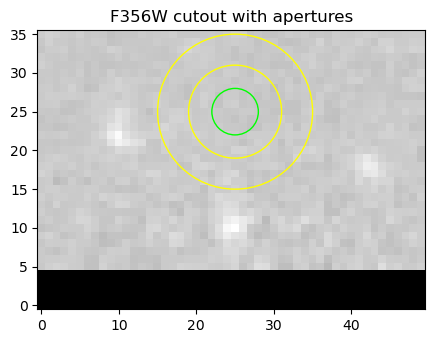

In [14]:
from astropy.nddata import Cutout2D
from photutils.aperture import CircularAperture, CircularAnnulus, aperture_photometry
from astropy.visualization import ZScaleInterval
import numpy as np, matplotlib.pyplot as plt

# helper: MJy/sr summed over pixels -> Jy using PIXAR_SR
def mjysr_sum_to_jy(sum_mjysr, pix_sr):
    if (pix_sr is None) or (not np.isfinite(pix_sr)):
        # Fallback: just return the summed surface brightness (unitless)
        return np.nan
    return sum_mjysr * 1e6 * pix_sr

def jy_to_abmag(f_jy):
    with np.errstate(divide='ignore', invalid='ignore'):
        return -2.5 * np.log10(f_jy / 3631.0)

def measure_aperture_flux(img, wcs, ra, dec, r_pix=3.0, rin=6.0, rout=10.0, pix_sr=None):
    # pixel center
    x, y = wcs.world_to_pixel_values(ra, dec)
    aper  = CircularAperture((x, y), r_pix)
    ann   = CircularAnnulus((x, y), rin, rout)

    # photometry
    phot_aper = aperture_photometry(img, aper, method='exact')
    phot_ann  = aperture_photometry(img, ann, method='exact')

    # background from annulus (median surface brightness)
    ann_mask = ann.to_mask(method='center')
    ann_data = ann_mask.multiply(img)
    ann_vals = ann_data[np.isfinite(ann_data)]
    if ann_vals.size > 0:
        bkg_sb = np.median(ann_vals)  # in MJy/sr
    else:
        bkg_sb = 0.0

    # background-subtracted sum inside aperture (MJy/sr * pix)
    aper_mask = aper.to_mask(method='center')
    aper_data = aper_mask.multiply(img)
    good = np.isfinite(aper_data)
    sum_sb = np.nansum(aper_data[good]) - bkg_sb * np.sum(good)

    # convert to Jy (if PIXAR_SR available), then AB mag
    f_jy = mjysr_sum_to_jy(sum_sb, pix_sr)
    mag  = jy_to_abmag(f_jy) if np.isfinite(f_jy) and f_jy > 0 else np.nan
    return f_jy, mag

# ---- run over bands & seed list ----
results = []
r_pix, rin, rout = 3.0, 6.0, 10.0  # keep consistent

for band in BANDS:
    img, wcs, pix_sr, bunit = load_sci_wcs(FILES[band])
    for i in range(len(seed)):
        f_jy, mag = measure_aperture_flux(img, wcs, seed["ra"][i], seed["dec"][i],
                                          r_pix=r_pix, rin=rin, rout=rout, pix_sr=pix_sr)
        results.append(dict(idx=int(seed["idx"][i]),
                            band=band, f_jy=f_jy, ABmag=mag,
                            bunit=bunit, pix_sr=pix_sr))

from astropy.table import Table
res_tbl = Table(rows=results, names=("idx","band","f_jy","ABmag","bunit","pix_sr"))
# pivot to one row per object if you like:
wide = res_tbl.group_by("idx")

print(res_tbl[:10])

# quick-look image and apertures for the first seed in the first band
first_band = BANDS[0]
img, wcs, _, _ = load_sci_wcs(FILES[first_band])
x0, y0 = wcs.world_to_pixel_values(seed["ra"][0], seed["dec"][0])
aper  = CircularAperture((x0, y0), r_pix)
ann   = CircularAnnulus((x0, y0), rin, rout)

sz = 50
cut = Cutout2D(img, (x0, y0), (sz, sz), wcs=wcs)
aper_cut = CircularAperture((sz/2, sz/2), r_pix)
ann_cut  = CircularAnnulus((sz/2, sz/2), rin, rout)

plt.figure(figsize=(5,5))
vmin, vmax = ZScaleInterval().get_limits(cut.data)
plt.imshow(cut.data, origin='lower', vmin=vmin, vmax=vmax, cmap='gray')
aper_cut.plot(color='lime')
ann_cut.plot(color='yellow')
plt.title(f"{first_band} cutout with apertures")
plt.show()


Saved: photometry_long.(csv|ecsv)
Saved: photometry_wide.csv


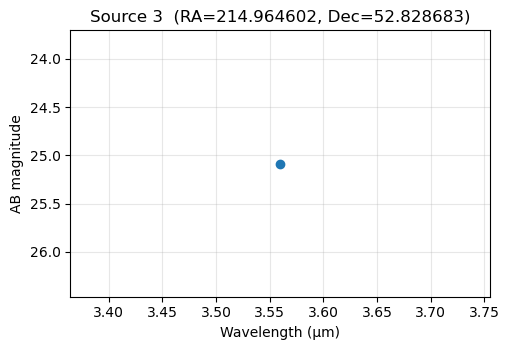

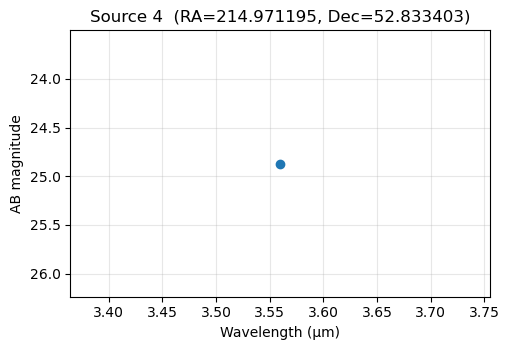

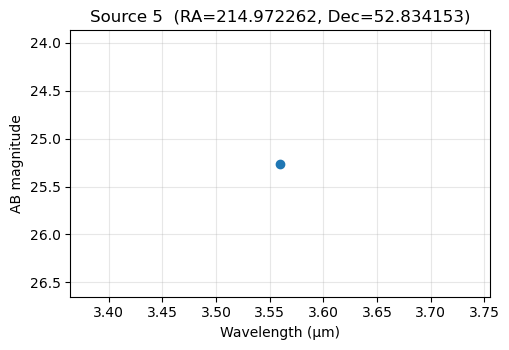

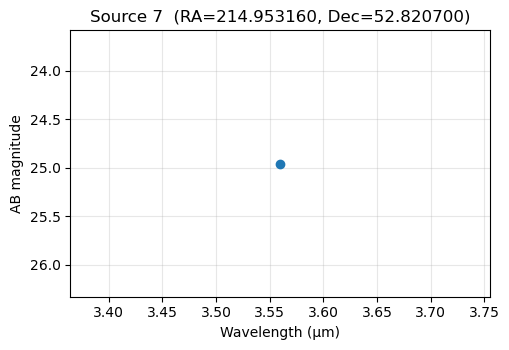

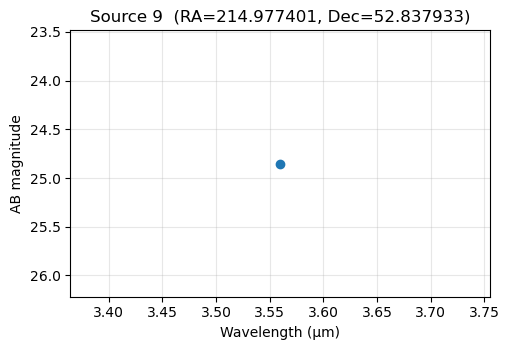

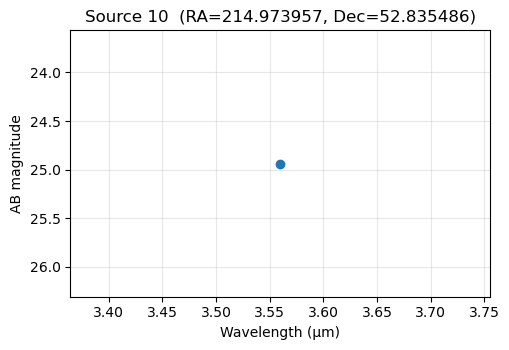

In [19]:
# === CELL 3 (fixed): normalize results, save tables, quick SED plots ===
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt
from astropy.table import Table

def table_to_df(obj):
    if obj is None: return None
    if isinstance(obj, Table): return obj.to_pandas()
    if isinstance(obj, list):  return pd.DataFrame(obj)
    if isinstance(obj, pd.DataFrame): return obj.copy()
    return None

def load_long_results(res_tbl):
    df = table_to_df(res_tbl)  # try in-memory
    if df is None:
        # fall back to disk
        if os.path.exists("photometry_long.ecsv"):
            df = Table.read("photometry_long.ecsv", format="ascii.ecsv").to_pandas()
        elif os.path.exists("photometry_long.csv"):
            df = pd.read_csv("photometry_long.csv")
        else:
            raise RuntimeError("No res_tbl in memory and no photometry_long.* on disk.")

    # ---- normalize column names ----
    rename_map = {}
    if "idx" not in df.columns:
        if "label" in df.columns: rename_map["label"] = "idx"
        elif "id" in df.columns:  rename_map["id"] = "idx"
    if "band" not in df.columns:
        if "filter" in df.columns:    rename_map["filter"] = "band"
        elif "bandpass" in df.columns: rename_map["bandpass"] = "band"

    # flux column variants
    if "flux_jy" not in df.columns:
        if "f_jy" in df.columns:          rename_map["f_jy"] = "flux_jy"
        elif "flux" in df.columns:        rename_map["flux"] = "flux_jy"
        elif "flux_ujy" in df.columns:    df["flux_jy"] = pd.to_numeric(df["flux_ujy"], errors="coerce") * 1e-6
        elif "fnu" in df.columns:         rename_map["fnu"] = "flux_jy"

    # magnitude variants
    if "mag_ab" not in df.columns:
        for cand in ["mag", "ABmag", "m_ab", "mag_AB"]:
            if cand in df.columns:
                rename_map[cand] = "mag_ab"
                break

    if rename_map:
        df = df.rename(columns=rename_map)

    # require these now
    required = {"idx","band","flux_jy","mag_ab"}
    missing = required - set(df.columns)
    if missing:
        raise RuntimeError(f"Long table is missing columns: {missing}. Columns present: {list(df.columns)}")

    # coerce types
    df["idx"] = pd.to_numeric(df["idx"], errors="coerce").astype(int)
    df["band"] = df["band"].astype(str)
    df["flux_jy"] = pd.to_numeric(df["flux_jy"], errors="coerce")
    df["mag_ab"] = pd.to_numeric(df["mag_ab"], errors="coerce")
    return df

def try_add_radec(df_wide, seed):
    # attach RA/Dec if your seed table exists with columns idx, ra, dec
    from astropy.table import Table
    def _to_df(x):
        if x is None: return None
        if isinstance(x, Table): return x.to_pandas()
        if isinstance(x, pd.DataFrame): return x
        return None
    s = _to_df(seed) if "seed" in globals() else None
    if s is None: return df_wide
    if "idx" not in s.columns and "label" in s.columns:
        s = s.rename(columns={"label":"idx"})
    if {"idx","ra","dec"}.issubset(s.columns):
        s2 = s[["idx","ra","dec"]].drop_duplicates()
        s2["idx"] = pd.to_numeric(s2["idx"], errors="coerce").astype(int)
        return df_wide.merge(s2, on="idx", how="left")
    return df_wide

# ---- run normalization ----
df_long = load_long_results(res_tbl if "res_tbl" in globals() else None)
df_long = df_long.sort_values(["idx","band"]).reset_index(drop=True)

# save long-form
df_long.to_csv("photometry_long.csv", index=False)
try:
    Table.from_pandas(df_long).write("photometry_long.ecsv", format="ascii.ecsv", overwrite=True)
except Exception:
    pass
print("Saved: photometry_long.(csv|ecsv)")

# pivot to wide (magnitudes + optional RA/Dec)
df_mag  = df_long.pivot_table(index="idx", columns="band", values="mag_ab",  aggfunc="first")
df_wide = df_mag.reset_index()
df_wide = try_add_radec(df_wide, seed if "seed" in globals() else None)

df_wide.to_csv("photometry_wide.csv", index=False)
print("Saved: photometry_wide.csv")

# quick SED plots
band_lambda = {"F200W":2.00, "F277W":2.77, "F356W":3.56, "F444W":4.44}
bands_present = [b for b in band_lambda if b in df_mag.columns]

K = min(6, len(df_mag))
for idx, row in df_mag.head(K).iterrows():
    lam  = np.array([band_lambda[b] for b in bands_present])
    mags = np.array([row.get(b, np.nan) for b in bands_present], dtype=float)
    det  = np.isfinite(mags)
    if not det.any(): continue
    title = f"Source {idx}"
    if "ra" in df_wide.columns and "dec" in df_wide.columns:
        try: title += f"  (RA={df_wide.loc[df_wide['idx']==idx,'ra'].iloc[0]:.6f}, Dec={df_wide.loc[df_wide['idx']==idx,'dec'].iloc[0]:.6f})"
        except Exception: pass
    plt.figure(figsize=(5.2,3.6))
    plt.plot(lam[det], mags[det], marker="o", linestyle="-")
    plt.gca().invert_yaxis()
    plt.xlabel("Wavelength (µm)")
    plt.ylabel("AB magnitude")
    plt.title(title)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


In [21]:
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
import astropy.units as u
import numpy as np
import glob, os

import warnings
from astropy.wcs import FITSFixedWarning
warnings.filterwarnings("ignore", category=FITSFixedWarning)

# --- your existing F356W file ---
F356W_FILE = "mast_data_testing/MAST_2025-11-16T1714/JWST/jw01345-o070_t053_nircam_clear-f356w/jw01345-o070_t053_nircam_clear-f356w_i2d.fits"

# Where you saved MIRI mosaics:
MIRI_DIR = "mast_data_testing/JWST_MIRI"

# Add/adjust bands you downloaded:
MIRI_BANDS = {
    "F560W": 5.60,
    "F770W": 7.70,
    "F1000W": 10.00,
    "F1280W": 12.80,
    "F1500W": 15.00,
    "F1800W": 18.00,
    "F2100W": 21.00,
}

def sky_box_from_i2d(path):
    """Return (RA array, DEC array) of the footprint corners and a center SkyCoord."""
    with fits.open(path) as hd:
        w = WCS(hd[1].header)
        ny, nx = hd[1].data.shape
    corners = np.array([[0,0],[nx,0],[nx,ny],[0,ny]])
    radec = w.wcs_pix2world(corners, 0)
    ra, dec = radec[:,0], radec[:,1]
    cen = SkyCoord(np.mean(ra)*u.deg, np.mean(dec)*u.deg)
    return ra, dec, cen

def boxes_overlap(ra1, dec1, ra2, dec2):
    """Fast bounding-box overlap in RA/Dec (works well for small fields)."""
    def bounds(ra, dec):
        return (ra.min(), ra.max(), dec.min(), dec.max())
    ra1min, ra1max, dec1min, dec1max = bounds(ra1, dec1)
    ra2min, ra2max, dec2min, dec2max = bounds(ra2, dec2)
    ra_overlap  = (ra1min <= ra2max) and (ra2min <= ra1max)
    dec_overlap = (dec1min <= dec2max) and (dec2min <= dec1max)
    return ra_overlap and dec_overlap

# F356W footprint:
f356_ra, f356_dec, f356_cen = sky_box_from_i2d(F356W_FILE)

# Find matching MIRI mosaics:
FILES = {"F356W": F356W_FILE}         # start with your NIRCam file
LAM   = {"F356W": 3.56}               # central wavelengths (µm)
for band, lam in MIRI_BANDS.items():
    pattern = os.path.join(MIRI_DIR, f"*{band.lower()}*i2d.fits").replace("f", "f").replace("w","w")
    cands = sorted(glob.glob(pattern))
    for path in cands:
        try:
            ra, dec, _ = sky_box_from_i2d(path)
            if boxes_overlap(f356_ra, f356_dec, ra, dec):
                FILES[band] = path
                LAM[band]   = lam
                break
        except Exception:
            continue

print("Matched files:")
for k in sorted(FILES.keys(), key=lambda b: LAM[b]):
    print(f"  {k:6s}  {LAM[k]:5.2f} µm  ->  {os.path.basename(FILES[k])}")


Matched files:
  F356W    3.56 µm  ->  jw01345-o070_t053_nircam_clear-f356w_i2d.fits


# Observation ID o013_t025

Using files:
  F115W: mast_data/o013_t025/nircam/F115W/MAST_2025-11-28T1637/JWST/jw01345-o013_t025_nircam_clear-f115w/jw01345-o013_t025_nircam_clear-f115w_i2d.fits
  F356W: mast_data/o013_t025/nircam/F356W/MAST_2025-11-28T1639/JWST/jw01345-o013_t025_nircam_clear-f356w/jw01345-o013_t025_nircam_clear-f356w_i2d.fits
  F560W: mast_data/o013_t025/miri/F560W/MAST_2025-11-28T1633/JWST/jw01345-o013_t025_miri_f560w/jw01345-o013_t025_miri_f560w_i2d.fits
  F770W: mast_data/o013_t025/miri/F770W/MAST_2025-11-28T1632/JWST/jw01345-o013_t025_miri_f770w/jw01345-o013_t025_miri_f770w_i2d.fits


Deblending:   0%|          | 0/2260 [00:00<?, ?it/s]

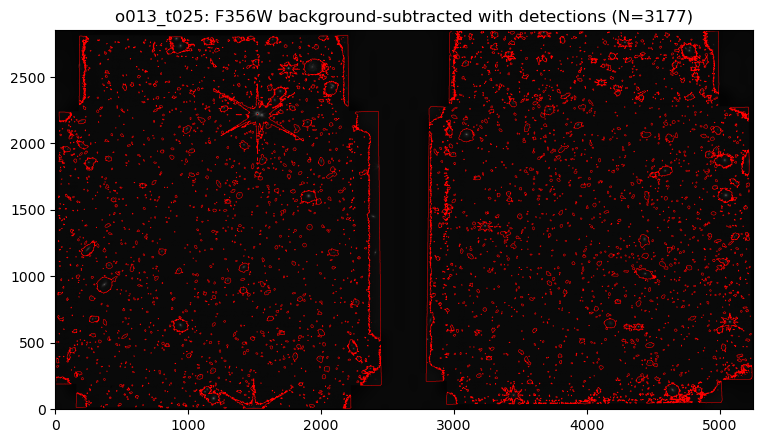

Seed catalog written: seed_o013_t025.ecsv  |  N=3177


idx,ra,dec,xcentroid,ycentroid,area
,deg,deg,,,
int64,float64,float64,float64,float64,float64
0,214.97376351208175,52.83045817862197,1277.3637983409267,10.487625184347579,117.0
1,214.98192817397594,52.836189564841426,844.6436275566181,10.785884584383602,99.0
2,214.96107150085427,52.82197508959685,1931.5912172894677,26.102298540090963,619.0
3,214.97724247806,52.83340449213455,1071.1235896695343,29.440084369656418,208.0
4,214.98617130369053,52.83944385626922,607.8200474195331,21.27340646293007,49.0
5,214.97798218945985,52.8337719758427,1038.4988283060698,23.79700964141101,58.0
6,214.9617502280581,52.82248632390718,1894.1071724750818,27.413505897343462,88.0
7,214.97980257153463,52.83535659995374,928.7238319468601,35.326679956391544,235.0


In [24]:
# ========= Cell 1 (fixed): setup + build seed catalog from F356W =========
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits
from astropy.table import Table
from astropy.wcs import WCS
from astropy.convolution import convolve, Gaussian2DKernel
from astropy.stats import SigmaClip
from astropy.coordinates import SkyCoord
import astropy.units as u

from photutils.background import Background2D, MedianBackground
from photutils.segmentation import detect_threshold, detect_sources, deblend_sources, SourceCatalog

# -------------------
# Config: choose tile
# -------------------
ROOT = Path("mast_data")
TILE = "o013_t025"             # change to "o016_t027" to switch tiles
SEED_OUT = f"seed_{TILE}.ecsv"

# -------------------------------------------------
# Helpers: locate files in your directory structure
# -------------------------------------------------
def pick_i2d(folder: Path) -> Path:
    """
    Recursively search for the *_i2d.fits under `folder`.
    Return the largest match (usually the mosaic).
    """
    if not folder.exists():
        raise FileNotFoundError(f"Folder does not exist: {folder}")
    candidates = list(folder.rglob("*_i2d.fits"))
    if not candidates:
        # help debug by showing any FITS present
        any_fits = list(folder.rglob("*.fits"))
        msg = f"No *_i2d.fits found under {folder}.\n"
        if any_fits:
            msg += "Found FITS files (showing up to 8):\n" + "\n".join(str(p) for p in any_fits[:8])
        else:
            msg += "No FITS files found at all under this folder."
        raise FileNotFoundError(msg)
    # pick the biggest (most often the combined mosaic)
    return max(candidates, key=lambda p: p.stat().st_size)

def file_map(tile: str) -> dict:
    base = ROOT / tile
    # In your tree: mast_data/<tile>/<instrument>/<filter>/MAST_.../JWST/...
    f356_dir = (base/"nircam"/"F356W")
    if not f356_dir.exists():   # some bundles label it F365W
        f356_dir = (base/"nircam"/"F365W")
    return {
        "F115W": pick_i2d(base / "nircam" / "F115W"),
        "F356W": pick_i2d(f356_dir),
        "F560W": pick_i2d(base / "miri"   / "F560W"),
        "F770W": pick_i2d(base / "miri"   / "F770W"),
    }

FILES = file_map(TILE)
print("Using files:")
for k, v in FILES.items():
    print(f"  {k}: {v}")

# --------------------------------------------
# Utility: safe array from Quantity/Masked cols
# --------------------------------------------
def q_to_float(col):
    try:
        arr = np.ma.filled(col.to_value(), np.nan).astype(float)
    except Exception:
        arr = np.ma.filled(col, np.nan).astype(float)
    return np.asarray(arr)

# ---------------------------------------------------------
# Build seed catalog (RA/Dec) from F356W compact detections
# ---------------------------------------------------------
def build_seed_from_f356w(f356_path: Path, show_plots: bool = True) -> Table:
    with fits.open(f356_path) as hdul:
        data = hdul[1].data.astype(float)
        hdr  = hdul[1].header
        wcs  = WCS(hdr)
    data = np.where(np.isfinite(data), data, 0.0)

    sigma_clip = SigmaClip(sigma=3.0, maxiters=5)
    bkg = Background2D(
        data, box_size=(96, 96), filter_size=(3, 3),
        bkg_estimator=MedianBackground(), sigma_clip=sigma_clip
    )
    resid = data - bkg.background

    smooth = convolve(resid, Gaussian2DKernel(x_stddev=1.0), normalize_kernel=True, boundary='extend')

    thresh = detect_threshold(smooth, nsigma=3.0)
    segm = detect_sources(smooth, thresh, npixels=20)
    segm = deblend_sources(smooth, segm, npixels=20, nlevels=32, contrast=0.001)

    cat = SourceCatalog(data=resid, segment_img=segm)
    tab = cat.to_table(columns=("label","xcentroid","ycentroid","area","semimajor_sigma","semiminor_sigma"))

    area = q_to_float(tab["area"])
    a    = q_to_float(tab["semimajor_sigma"])
    b    = q_to_float(tab["semiminor_sigma"])
    with np.errstate(divide='ignore', invalid='ignore'):
        ell = 1.0 - (b / np.where(a > 0, a, np.nan))

    keep = (area >= 40.0) & np.isfinite(ell) & (ell < 0.95)
    kept = tab[keep]

    x = q_to_float(kept["xcentroid"])
    y = q_to_float(kept["ycentroid"])
    sky = wcs.pixel_to_world(x, y)

    seed = Table()
    seed["idx"]        = np.arange(len(kept), dtype=int)
    seed["ra"]         = sky.ra.to(u.deg)
    seed["dec"]        = sky.dec.to(u.deg)
    seed["xcentroid"]  = x
    seed["ycentroid"]  = y
    seed["area"]       = area[keep]

    if show_plots:
        plt.figure(figsize=(9,6))
        plt.imshow(np.log10(resid + 1), origin='lower', cmap='gray')
        plt.contour(segm.data > 0, levels=[0.5], colors='r', linewidths=0.35)
        plt.title(f"{TILE}: F356W background-subtracted with detections (N={len(seed)})")
        plt.show()

    return seed

seed = build_seed_from_f356w(FILES["F356W"], show_plots=True)
seed.write(SEED_OUT, format="ascii.ecsv", overwrite=True)
print(f"Seed catalog written: {SEED_OUT}  |  N={len(seed)}")
seed[:10]


In [27]:
# PREP: build o013_t025_detections.ecsv (RA/Dec seed list) from F356W
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS
from astropy.table import Table
from astropy.stats import SigmaClip
from astropy.convolution import Gaussian2DKernel, convolve
from photutils.background import Background2D, MedianBackground
from photutils.segmentation import detect_threshold, detect_sources, deblend_sources
from photutils.segmentation import SourceCatalog

# ---- point this at your already-defined FILES mapping and TILE ----
# If you don't have FILES in memory, set:
# F356W_FILE = "mast_data/o013_t025/nircam/F356W/<your>_i2d.fits"
F356W_FILE = FILES["F356W"]  # uses mapping from earlier cell

with fits.open(F356W_FILE) as hdul:
    img = np.asarray(hdul[1].data, dtype=float)
    hdr = hdul[1].header
w = WCS(hdr)

# Background subtraction
sigma_clip = SigmaClip(sigma=3.0, maxiters=5)
bkg = Background2D(img, box_size=(96, 96), filter_size=(3, 3),
                   bkg_estimator=MedianBackground(), sigma_clip=sigma_clip)
resid = img - bkg.background

# Smooth a bit to help detection
smooth = convolve(resid, Gaussian2DKernel(x_stddev=1.0), normalize_kernel=True, boundary="extend")

# Segment + deblend
thresh = detect_threshold(smooth, nsigma=3.0)
segm = detect_sources(smooth, thresh, npixels=20)
segm = deblend_sources(smooth, segm, npixels=20, nlevels=32, contrast=0.001)

# Catalog and basic pruning (small/elongated artifacts)
cat = SourceCatalog(resid, segm)
tab = cat.to_table(columns=("label","xcentroid","ycentroid","area","semimajor_sigma","semiminor_sigma"))

# convert to floats
def asfloat(col): 
    import numpy as _np, numpy.ma as _ma
    try: return _np.asarray(_ma.filled(col.to_value(), np.nan), dtype=float)
    except Exception: return _np.asarray(_ma.filled(col, np.nan), dtype=float)

area = asfloat(tab["area"])
a = asfloat(tab["semimajor_sigma"])
b = asfloat(tab["semiminor_sigma"])
ell = 1.0 - np.divide(b, np.where(a>0, a, np.nan))

keep = (area >= 40.0) & np.isfinite(ell) & (ell < 0.95)
x = asfloat(tab["xcentroid"])[keep]
y = asfloat(tab["ycentroid"])[keep]

# Pixel -> sky
ra, dec = w.pixel_to_world_values(x, y)

seed = Table(dict(idx=np.arange(len(ra), dtype=int), ra=ra, dec=dec))
seed.write("o013_t025_detections.ecsv", overwrite=True)
print(f"Saved seed list with {len(seed)} positions to o013_t025_detections.ecsv")


Deblending:   0%|          | 0/2338 [00:00<?, ?it/s]

Saved seed list with 2800 positions to o013_t025_detections.ecsv


# Observation ID o016_t027